# Continual Integration of Mosaic Single-cell Data (RNA+ADT+ATAC)

This tutorial demonstrates the continual integration of a single-cell dataset across 8 batches. We'll first train a base model on batch 1, then incrementally update it with subsequent batches. Finally, we'll show how to package the integrated data for future use.

## 1. Initialization and Environment Setup
This section imports necessary libraries, defines global paths and parameters, and sets up a reproducible environment.

In [1]:
option(warn=-1)

NameError: name 'option' is not defined

In [1]:
import os
import gc
import lightning as L
import numpy as np
import pandas as pd
import scanpy as sc

# Import custom modules from the scMIDAS library
from scmiracle.config import load_config
from scmiracle.data import download_data
from scmiracle.model import MIDAS
from scmiracle.utils import calculate_loss_scale, plot_umap

# --- Global Configurations ---
# Use os.path.join for cross-platform path compatibility
BASE_DATA_PATH = '/dev/shm/processed'
DATASET_NAME = 'DOTEA_mtx'
DATA_PATH = os.path.join(BASE_DATA_PATH, DATASET_NAME)
SAVE_MODEL_DIR = 'saved_models'

# --- GPU Configuration ---
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# --- Scanpy Plotting Parameters ---
sc.set_figure_params(figsize=(4, 4))

# --- Global Random Seed ---
# Set a global random seed for reproducibility
L.seed_everything(42)

# --- Dataset and Model Parameters ---
# Number of cells per batch, used for calculating loss weights
NUM_CELLS_PER_BATCH = np.array([9579, 9096, 7318, 4817, 5342, 6181, 4163, 6860])
# Number of workers for data loading; adjust based on your CPU core count
NUM_WORKERS = 64
# Training epochs: 2000 for the base model, 1000 for each incremental step
NUM_EPOCH = [2000] + [1000] * 7

Seed set to 42


## 2. Data Preparation

**Note**: This data is pre-processed to simulate an online learning scenario. For RNA and ADT, features in new batches are aligned with existing features (reference features first, new features last). ATAC features are consistent across all batches.

In [ ]:
download_data(DATASET_NAME, BASE_DATA_PATH)
labels = [pd.read_csv(os.path.join(DATA_PATH, f'label/P{i+1}_l1.csv'), index_col=0).values.flatten() for i in range(8)]

## 3. Stage 1: Base Model Training on Batch 1

This step follows the standard MIDAS training procedure to build a robust initial model using the first batch.

INFO:root:The model is initialized with the default configurations.



--- Stage 1: Training the base model on Batch 1 ---


INFO:root:Input data: 
         #CELL  #ADT  #ATAC  #VALID_ADT
BATCH 0   9579   208  31787         208
INFO:root:Defining new network structure...
INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Visualizing results with UMAP...


/root/anaconda3/envs/scmidas3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
... storing 'batch' as categorical
... storing 'label' as categorical


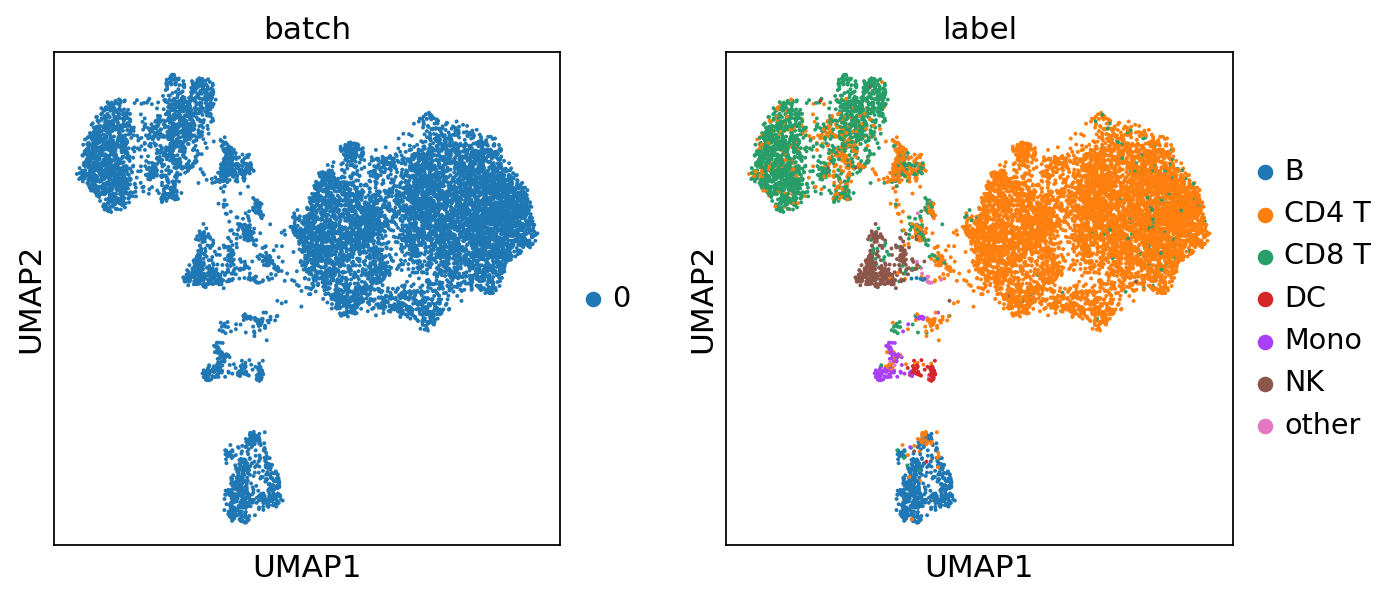

74532

In [ ]:
print("\n--- Stage 1: Training the base model on Batch 1 ---")

# Reset the MIDAS model state for a clean start
MIDAS.reset()
configs = load_config()
configs['num_workers'] = NUM_WORKERS

# Configure the data and model from the first batch directory
model = MIDAS.configure_data_from_dir(
    configs=configs,
    dir_path=os.path.join(DATA_PATH, 'data/DOTEA_P1/'),
    save_model_path=os.path.join(SAVE_MODEL_DIR, 'DOTAE_P1_mtx/'),
    format='mtx',
    transform={'atac': 'binarize'} # Binarize ATAC data
)

# Initialize and fit with a Lightning Trainer (approx. 100 mins for 2000 epochs)
trainer = L.Trainer(max_epochs=NUM_EPOCH[0])
trainer.fit(model=model)

# Generate predictions and visualize the latent space
pred = model.predict()
plot_umap(pred, labels[0])

## 4. Stage 2: Continual Training on Batches 2-8
Here, we simulate a scenario where new data arrives sequentially. Each new batch is used to incrementally update the previously trained model.

INFO:root:Input data: 
         #CELL   #ADT  #ATAC    #RNA  #VALID_ADT  #VALID_RNA
BATCH 0   9579  208.0  31787     NaN       208.0         NaN
BATCH 1   9096    NaN  31787  4052.0         NaN      4052.0
INFO:root:Loading pre-defined network structure...
INFO:root:Model1 updated successfully with weights from model2 (left-aligned strategy).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | net  | VAE           | 18.8 M | train
1 | dsc  | Discriminator | 51.8 K | train
-----------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.567    Total estimated model params size (MB)
676       Modules in train mode
0         Modules in eval mode
INFO:root:Total number of samples: 18675 from 2 datasets.
/root/anaconda3/envs/sc

Epoch 499: 100%|██████████| 72/72 [00:08<00:00,  8.18it/s, v_num=146, loss_/recon_loss_step=9.47e+3, loss_/kld_loss_step=98.30, loss_/consistency_loss_step=19.80, loss/net_step=9.54e+3, loss/dsc_step=39.10, loss_/recon_loss_epoch=1.04e+4, loss_/kld_loss_epoch=99.40, loss_/consistency_loss_epoch=21.00, loss/net_epoch=1.05e+4, loss/dsc_epoch=38.50]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P2_mtx/model_epoch500_20251119-165153.pt".


Epoch 999: 100%|██████████| 72/72 [00:09<00:00,  7.73it/s, v_num=146, loss_/recon_loss_step=9.52e+3, loss_/kld_loss_step=98.10, loss_/consistency_loss_step=20.40, loss/net_step=9.6e+3, loss/dsc_step=39.60, loss_/recon_loss_epoch=1.04e+4, loss_/kld_loss_epoch=99.60, loss_/consistency_loss_epoch=19.10, loss/net_epoch=1.04e+4, loss/dsc_epoch=38.70] 

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P2_mtx/model_epoch1000_20251119-180517.pt".
`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 72/72 [00:10<00:00,  7.18it/s, v_num=146, loss_/recon_loss_step=9.52e+3, loss_/kld_loss_step=98.10, loss_/consistency_loss_step=20.40, loss/net_step=9.6e+3, loss/dsc_step=39.60, loss_/recon_loss_epoch=1.04e+4, loss_/kld_loss_epoch=99.60, loss_/consistency_loss_epoch=19.10, loss/net_epoch=1.04e+4, loss/dsc_epoch=38.70]


INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P2_mtx/model_epoch1000_20251119-180518.pt".
INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


Visualizing results with UMAP...


... storing 'batch' as categorical
... storing 'label' as categorical


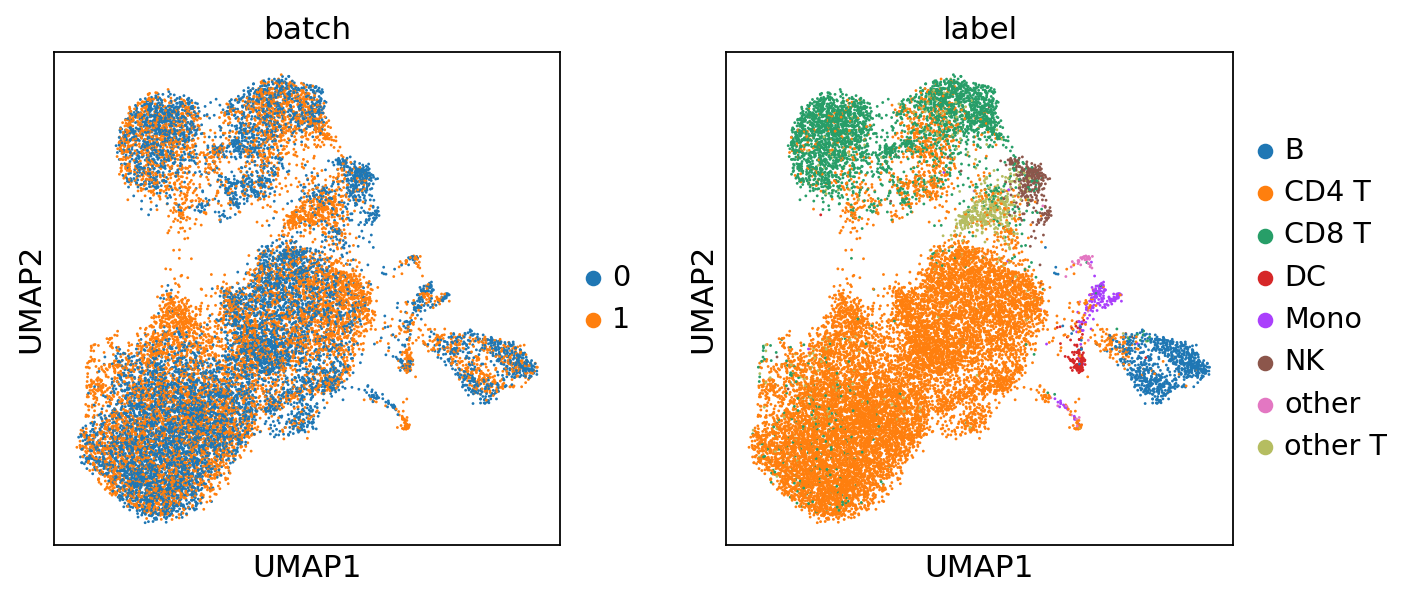

INFO:root:Input data: 
         #CELL   #ADT    #ATAC    #RNA  #VALID_ADT  #VALID_RNA
BATCH 0   9579  208.0  31787.0     NaN       208.0         NaN
BATCH 1   9096    NaN  31787.0  4959.0         NaN      4052.0
BATCH 2   7318  208.0      NaN  4959.0       208.0      4063.0
INFO:root:Loading pre-defined network structure...
INFO:root:Model1 updated successfully with weights from model2 (left-aligned strategy).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | net  | VAE           | 20.7 M | train
1 | dsc  | Discriminator | 52.0 K | train
-----------------------------------------------
20.8 M    Trainable params
0         Non-trainable params
20.8 M    Total params
83.009    Total estimated model params size (MB)
676       Modules in train mode
0         Modules in eval mode
INFO:root:To

Epoch 499: 100%|██████████| 58/58 [00:07<00:00,  8.07it/s, v_num=147, loss_/recon_loss_step=1.08e+4, loss_/kld_loss_step=109.0, loss_/consistency_loss_step=17.00, loss/net_step=1.08e+4, loss/dsc_step=116.0, loss_/recon_loss_epoch=6.55e+3, loss_/kld_loss_epoch=105.0, loss_/consistency_loss_epoch=21.60, loss/net_epoch=6.61e+3, loss/dsc_epoch=70.90]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P3_mtx/model_epoch500_20251119-185901.pt".


Epoch 999: 100%|██████████| 58/58 [00:05<00:00, 10.64it/s, v_num=147, loss_/recon_loss_step=9.56e+3, loss_/kld_loss_step=108.0, loss_/consistency_loss_step=17.10, loss/net_step=9.58e+3, loss/dsc_step=112.0, loss_/recon_loss_epoch=6.5e+3, loss_/kld_loss_epoch=105.0, loss_/consistency_loss_epoch=21.40, loss/net_epoch=6.56e+3, loss/dsc_epoch=71.10] 

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P3_mtx/model_epoch1000_20251119-195214.pt".
`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 58/58 [00:06<00:00,  9.41it/s, v_num=147, loss_/recon_loss_step=9.56e+3, loss_/kld_loss_step=108.0, loss_/consistency_loss_step=17.10, loss/net_step=9.58e+3, loss/dsc_step=112.0, loss_/recon_loss_epoch=6.5e+3, loss_/kld_loss_epoch=105.0, loss_/consistency_loss_epoch=21.40, loss/net_epoch=6.56e+3, loss/dsc_epoch=71.10]


INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P3_mtx/model_epoch1000_20251119-195214.pt".
INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
100%|██████████| 3/3 [00:11<00:00,  3.98s/it]


Visualizing results with UMAP...


... storing 'batch' as categorical
... storing 'label' as categorical


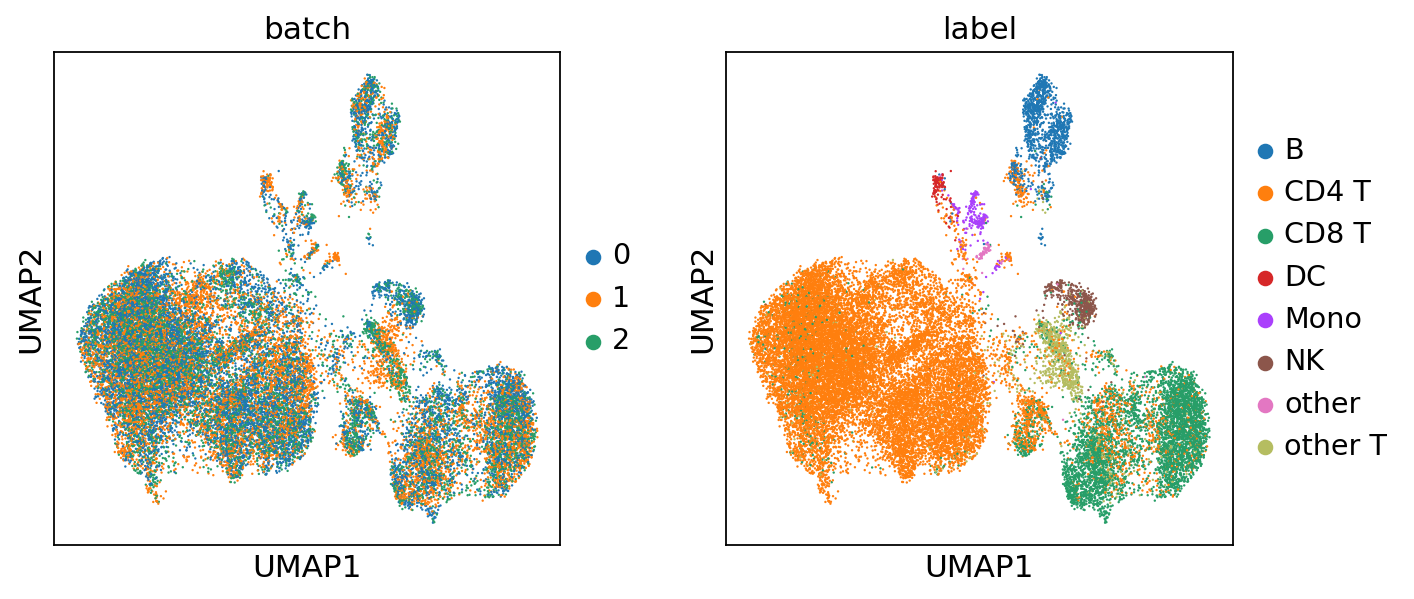

INFO:root:Input data: 
         #CELL   #ADT    #ATAC    #RNA  #VALID_ADT  #VALID_RNA
BATCH 0   9579  208.0  31787.0     NaN       208.0         NaN
BATCH 1   9096    NaN  31787.0  5439.0         NaN      4052.0
BATCH 2   7318  208.0      NaN  5439.0       208.0      4063.0
BATCH 3   4817  208.0  31787.0  5439.0       208.0      4050.0
INFO:root:Loading pre-defined network structure...
INFO:root:Model1 updated successfully with weights from model2 (left-aligned strategy).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | net  | VAE           | 21.7 M | train
1 | dsc  | Discriminator | 52.3 K | train
-----------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.948    Total estimated model params size (MB)
676       Mo

Epoch 499: 100%|██████████| 38/38 [00:05<00:00,  7.43it/s, v_num=148, loss_/recon_loss_step=1.1e+4, loss_/kld_loss_step=119.0, loss_/consistency_loss_step=12.50, loss/net_step=1.09e+4, loss/dsc_step=200.0, loss_/recon_loss_epoch=1.08e+4, loss_/kld_loss_epoch=120.0, loss_/consistency_loss_epoch=19.80, loss/net_epoch=1.08e+4, loss/dsc_epoch=114.0] 

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P4_mtx/model_epoch500_20251119-203607.pt".


Epoch 999: 100%|██████████| 38/38 [00:05<00:00,  7.11it/s, v_num=148, loss_/recon_loss_step=9.76e+3, loss_/kld_loss_step=117.0, loss_/consistency_loss_step=13.50, loss/net_step=9.69e+3, loss/dsc_step=192.0, loss_/recon_loss_epoch=1.07e+4, loss_/kld_loss_epoch=120.0, loss_/consistency_loss_epoch=22.00, loss/net_epoch=1.07e+4, loss/dsc_epoch=112.0]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P4_mtx/model_epoch1000_20251119-211909.pt".
`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 38/38 [00:06<00:00,  6.21it/s, v_num=148, loss_/recon_loss_step=9.76e+3, loss_/kld_loss_step=117.0, loss_/consistency_loss_step=13.50, loss/net_step=9.69e+3, loss/dsc_step=192.0, loss_/recon_loss_epoch=1.07e+4, loss_/kld_loss_epoch=120.0, loss_/consistency_loss_epoch=22.00, loss/net_epoch=1.07e+4, loss/dsc_epoch=112.0]


INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P4_mtx/model_epoch1000_20251119-211910.pt".
INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
100%|██████████| 4/4 [00:16<00:00,  4.21s/it]


Visualizing results with UMAP...


... storing 'batch' as categorical
... storing 'label' as categorical


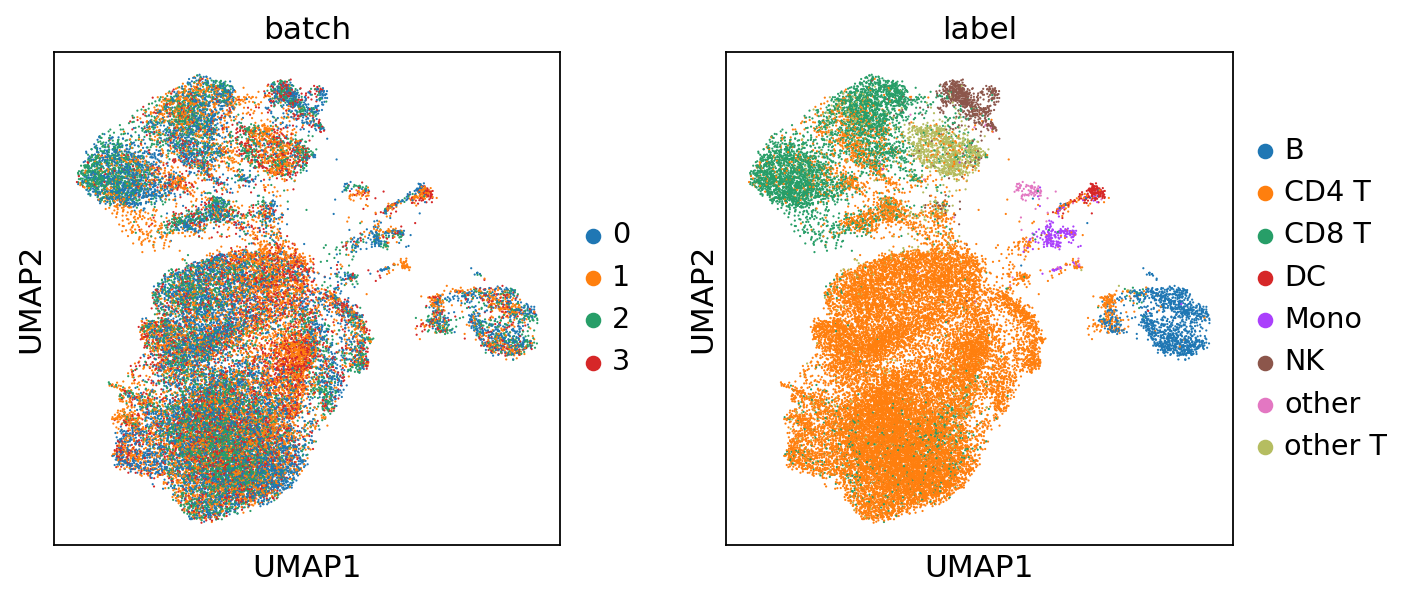

INFO:root:Input data: 
         #CELL   #ADT    #ATAC    #RNA  #VALID_ADT  #VALID_RNA
BATCH 0   9579  213.0  31787.0     NaN       208.0         NaN
BATCH 1   9096    NaN  31787.0  5439.0         NaN      4052.0
BATCH 2   7318  213.0      NaN  5439.0       208.0      4063.0
BATCH 3   4817  213.0  31787.0  5439.0       208.0      4050.0
BATCH 4   5342  213.0  31787.0     NaN        45.0         NaN
INFO:root:Loading pre-defined network structure...
INFO:root:Model1 updated successfully with weights from model2 (left-aligned strategy).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | net  | VAE           | 21.7 M | train
1 | dsc  | Discriminator | 52.5 K | train
-----------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total param

Epoch 499: 100%|██████████| 42/42 [00:05<00:00,  8.15it/s, v_num=149, loss_/recon_loss_step=1.12e+4, loss_/kld_loss_step=104.0, loss_/consistency_loss_step=52.50, loss/net_step=1.12e+4, loss/dsc_step=170.0, loss_/recon_loss_epoch=8.66e+3, loss_/kld_loss_epoch=107.0, loss_/consistency_loss_epoch=22.70, loss/net_epoch=8.66e+3, loss/dsc_epoch=124.0]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P5_mtx/model_epoch500_20251119-220406.pt".


Epoch 999: 100%|██████████| 42/42 [00:05<00:00,  7.64it/s, v_num=149, loss_/recon_loss_step=2.84e+3, loss_/kld_loss_step=112.0, loss_/consistency_loss_step=19.30, loss/net_step=2.76e+3, loss/dsc_step=207.0, loss_/recon_loss_epoch=8.52e+3, loss_/kld_loss_epoch=107.0, loss_/consistency_loss_epoch=24.10, loss/net_epoch=8.53e+3, loss/dsc_epoch=125.0]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P5_mtx/model_epoch1000_20251119-224744.pt".
`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 42/42 [00:06<00:00,  6.70it/s, v_num=149, loss_/recon_loss_step=2.84e+3, loss_/kld_loss_step=112.0, loss_/consistency_loss_step=19.30, loss/net_step=2.76e+3, loss/dsc_step=207.0, loss_/recon_loss_epoch=8.52e+3, loss_/kld_loss_epoch=107.0, loss_/consistency_loss_epoch=24.10, loss/net_epoch=8.53e+3, loss/dsc_epoch=125.0]


INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P5_mtx/model_epoch1000_20251119-224745.pt".
INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


Visualizing results with UMAP...


... storing 'batch' as categorical
... storing 'label' as categorical


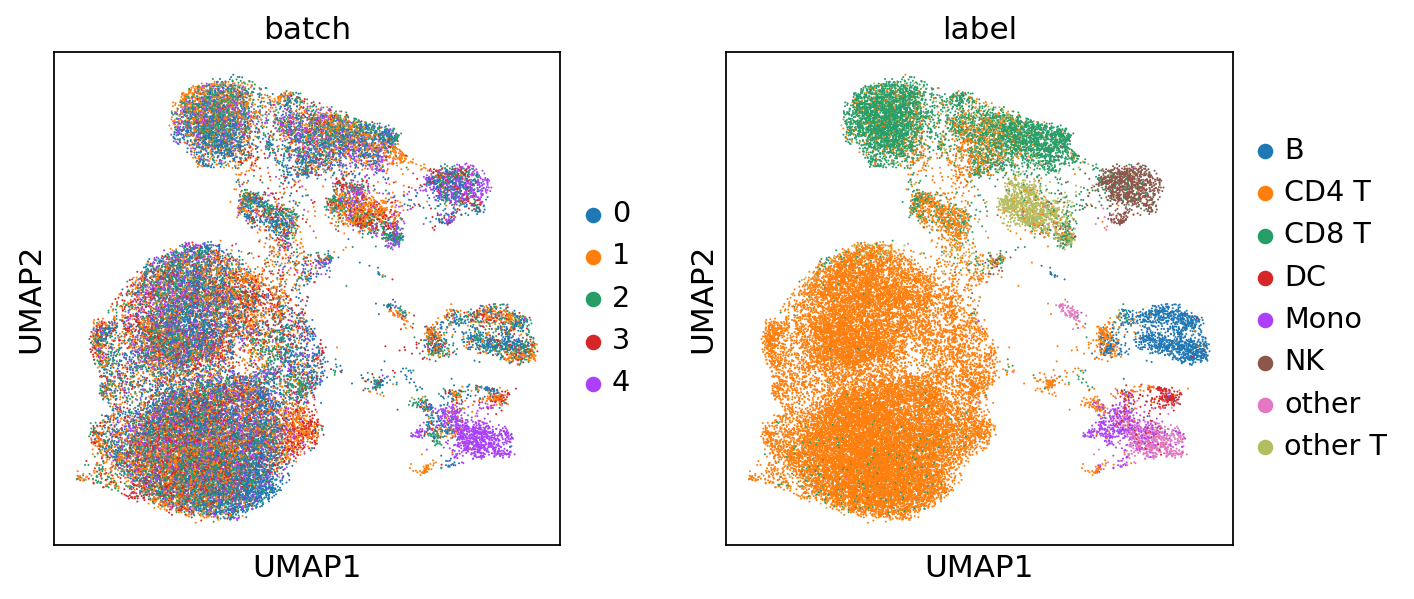

INFO:root:Input data: 
         #CELL   #ADT    #ATAC    #RNA  #VALID_ADT  #VALID_RNA
BATCH 0   9579  213.0  31787.0     NaN       208.0         NaN
BATCH 1   9096    NaN  31787.0  6606.0         NaN      4052.0
BATCH 2   7318  213.0      NaN  6606.0       208.0      4063.0
BATCH 3   4817  213.0  31787.0  6606.0       208.0      4050.0
BATCH 4   5342  213.0  31787.0     NaN        45.0         NaN
BATCH 5   6181    NaN  31787.0  6606.0         NaN      4064.0
INFO:root:Loading pre-defined network structure...
INFO:root:Model1 updated successfully with weights from model2 (left-aligned strategy).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | net  | VAE           | 24.1 M | train
1 | dsc  | Discriminator | 52.7 K | train
-----------------------------------------------
24.1 M    Traina

Epoch 499: 100%|██████████| 50/50 [00:06<00:00,  7.68it/s, v_num=150, loss_/recon_loss_step=7.97e+3, loss_/kld_loss_step=110.0, loss_/consistency_loss_step=21.70, loss/net_step=7.87e+3, loss/dsc_step=233.0, loss_/recon_loss_epoch=9.33e+3, loss_/kld_loss_epoch=107.0, loss_/consistency_loss_epoch=25.20, loss/net_epoch=9.33e+3, loss/dsc_epoch=134.0]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P6_mtx/model_epoch500_20251119-234229.pt".


Epoch 999: 100%|██████████| 50/50 [00:06<00:00,  7.66it/s, v_num=150, loss_/recon_loss_step=1.13e+4, loss_/kld_loss_step=110.0, loss_/consistency_loss_step=22.30, loss/net_step=1.12e+4, loss/dsc_step=265.0, loss_/recon_loss_epoch=8.92e+3, loss_/kld_loss_epoch=107.0, loss_/consistency_loss_epoch=25.30, loss/net_epoch=8.91e+3, loss/dsc_epoch=138.0]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P6_mtx/model_epoch1000_20251120-003450.pt".
`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 50/50 [00:07<00:00,  6.78it/s, v_num=150, loss_/recon_loss_step=1.13e+4, loss_/kld_loss_step=110.0, loss_/consistency_loss_step=22.30, loss/net_step=1.12e+4, loss/dsc_step=265.0, loss_/recon_loss_epoch=8.92e+3, loss_/kld_loss_epoch=107.0, loss_/consistency_loss_epoch=25.30, loss/net_epoch=8.91e+3, loss/dsc_epoch=138.0]


INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P6_mtx/model_epoch1000_20251120-003451.pt".
INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


Visualizing results with UMAP...


... storing 'batch' as categorical
... storing 'label' as categorical


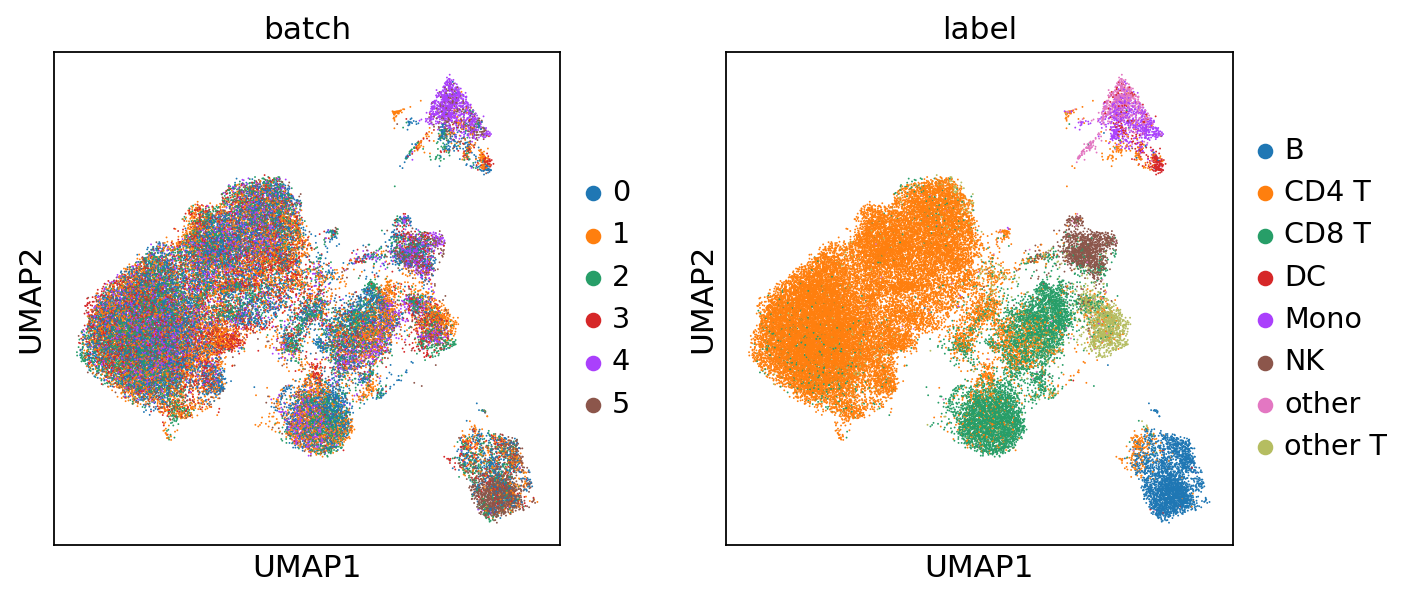

INFO:root:Input data: 
         #CELL   #ADT    #ATAC    #RNA  #VALID_ADT  #VALID_RNA
BATCH 0   9579  213.0  31787.0     NaN       208.0         NaN
BATCH 1   9096    NaN  31787.0  7077.0         NaN      4052.0
BATCH 2   7318  213.0      NaN  7077.0       208.0      4063.0
BATCH 3   4817  213.0  31787.0  7077.0       208.0      4050.0
BATCH 4   5342  213.0  31787.0     NaN        45.0         NaN
BATCH 5   6181    NaN  31787.0  7077.0         NaN      4064.0
BATCH 6   4163  213.0      NaN  7077.0        45.0      4071.0
INFO:root:Loading pre-defined network structure...
INFO:root:Model1 updated successfully with weights from model2 (left-aligned strategy).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | net  | VAE           | 25.1 M | train
1 | dsc  | Discriminator | 52.9 K | train
-

Epoch 499: 100%|██████████| 34/34 [00:03<00:00, 10.12it/s, v_num=151, loss_/recon_loss_step=1.36e+4, loss_/kld_loss_step=133.0, loss_/consistency_loss_step=41.80, loss/net_step=1.34e+4, loss/dsc_step=332.0, loss_/recon_loss_epoch=6.08e+3, loss_/kld_loss_epoch=109.0, loss_/consistency_loss_epoch=26.80, loss/net_epoch=6.08e+3, loss/dsc_epoch=133.0]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P7_mtx/model_epoch500_20251120-010859.pt".


Epoch 999: 100%|██████████| 34/34 [00:03<00:00,  8.94it/s, v_num=151, loss_/recon_loss_step=9.18e+3, loss_/kld_loss_step=114.0, loss_/consistency_loss_step=17.70, loss/net_step=9.06e+3, loss/dsc_step=254.0, loss_/recon_loss_epoch=5.37e+3, loss_/kld_loss_epoch=111.0, loss_/consistency_loss_epoch=22.30, loss/net_epoch=5.37e+3, loss/dsc_epoch=128.0]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P7_mtx/model_epoch1000_20251120-014007.pt".
`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 34/34 [00:20<00:00,  1.64it/s, v_num=151, loss_/recon_loss_step=9.18e+3, loss_/kld_loss_step=114.0, loss_/consistency_loss_step=17.70, loss/net_step=9.06e+3, loss/dsc_step=254.0, loss_/recon_loss_epoch=5.37e+3, loss_/kld_loss_epoch=111.0, loss_/consistency_loss_epoch=22.30, loss/net_epoch=5.37e+3, loss/dsc_epoch=128.0]


INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P7_mtx/model_epoch1000_20251120-014023.pt".
INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
100%|██████████| 7/7 [00:35<00:00,  5.08s/it]


Visualizing results with UMAP...


... storing 'batch' as categorical
... storing 'label' as categorical


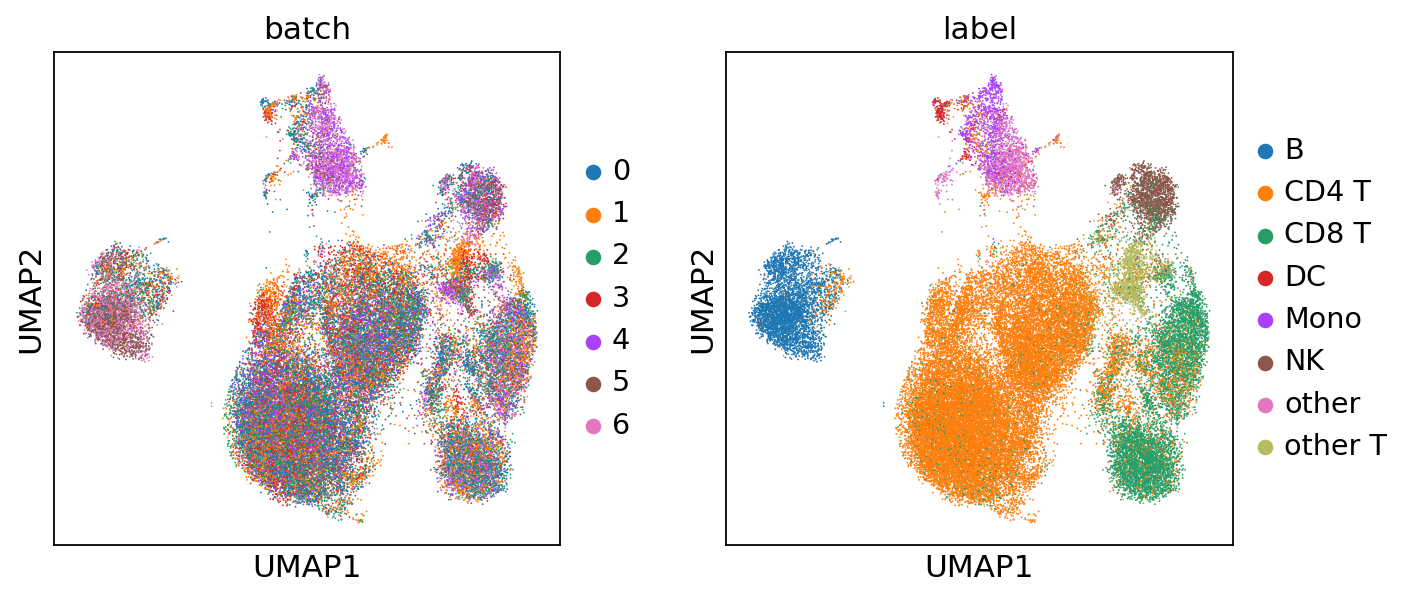

INFO:root:Input data: 
         #CELL   #ADT    #ATAC    #RNA  #VALID_ADT  #VALID_RNA
BATCH 0   9579  213.0  31787.0     NaN       208.0         NaN
BATCH 1   9096    NaN  31787.0  7304.0         NaN      4052.0
BATCH 2   7318  213.0      NaN  7304.0       208.0      4063.0
BATCH 3   4817  213.0  31787.0  7304.0       208.0      4050.0
BATCH 4   5342  213.0  31787.0     NaN        45.0         NaN
BATCH 5   6181    NaN  31787.0  7304.0         NaN      4064.0
BATCH 6   4163  213.0      NaN  7304.0        45.0      4071.0
BATCH 7   6860  213.0  31787.0  7304.0        45.0      4064.0
INFO:root:Loading pre-defined network structure...
INFO:root:Model1 updated successfully with weights from model2 (left-aligned strategy).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | net  | VAE        

Epoch 499: 100%|██████████| 54/54 [00:07<00:00,  7.35it/s, v_num=152, loss_/recon_loss_step=1.37e+4, loss_/kld_loss_step=136.0, loss_/consistency_loss_step=28.20, loss/net_step=1.33e+4, loss/dsc_step=486.0, loss_/recon_loss_epoch=8.84e+3, loss_/kld_loss_epoch=121.0, loss_/consistency_loss_epoch=22.00, loss/net_epoch=8.81e+3, loss/dsc_epoch=176.0]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P8_mtx/model_epoch500_20251120-024326.pt".


Epoch 999: 100%|██████████| 54/54 [00:07<00:00,  7.28it/s, v_num=152, loss_/recon_loss_step=2.93e+3, loss_/kld_loss_step=134.0, loss_/consistency_loss_step=13.00, loss/net_step=2.77e+3, loss/dsc_step=301.0, loss_/recon_loss_epoch=8.59e+3, loss_/kld_loss_epoch=121.0, loss_/consistency_loss_epoch=23.20, loss/net_epoch=8.55e+3, loss/dsc_epoch=181.0]

INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P8_mtx/model_epoch1000_20251120-034354.pt".
`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 54/54 [00:08<00:00,  6.46it/s, v_num=152, loss_/recon_loss_step=2.93e+3, loss_/kld_loss_step=134.0, loss_/consistency_loss_step=13.00, loss/net_step=2.77e+3, loss/dsc_step=301.0, loss_/recon_loss_epoch=8.59e+3, loss_/kld_loss_epoch=121.0, loss_/consistency_loss_epoch=23.20, loss/net_epoch=8.55e+3, loss/dsc_epoch=181.0]


INFO:root:Checkpoint successfully saved to "saved_models/DOTAE_P8_mtx/model_epoch1000_20251120-034355.pt".
INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
100%|██████████| 8/8 [00:40<00:00,  5.10s/it]


Visualizing results with UMAP...


... storing 'batch' as categorical
... storing 'label' as categorical


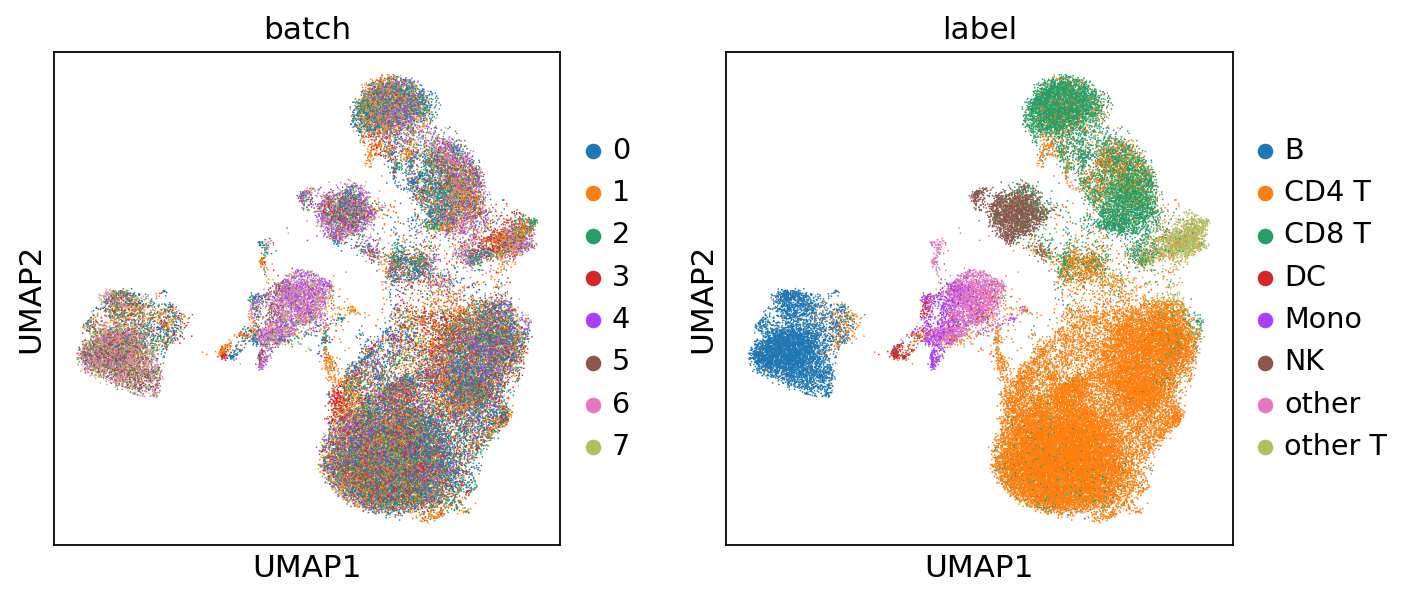

In [ ]:
print("\n--- Stage 2: Continual Training on Batches 2-8 ---")

for step in range(1, 8):
    print(f"\n--- Processing Batch {step + 1} ---")

    # Calculate loss scale factor to balance contributions from old and new data
    scale = calculate_loss_scale(NUM_CELLS_PER_BATCH[:step], NUM_CELLS_PER_BATCH[[step]])

    # Configure the new incremental learning task based on the existing model
    miracle = MIDAS.configure_new_data_from_dir(
        configs=configs,
        dir_path=os.path.join(DATA_PATH, f'data/DOTEA_P{step+1}/'),
        save_model_path=os.path.join(SAVE_MODEL_DIR, f'DOTAE_P{step+1}_mtx/'),
        format='mtx',
        transform={'atac': 'binarize'},
        scale=scale  # Apply the calculated loss scale
    )

    # Train on the new data
    trainer = L.Trainer(max_epochs=NUM_EPOCH[step])
    trainer.fit(model=miracle)

    # Predict on all data processed so far and visualize
    pred = miracle.predict()
    plot_umap(pred, np.concatenate(labels[:step+1]))

## 5. Save Unified Data for Future Use
After processing all batches, we can package the unified data. This allows you to quickly initialize a model with the fully integrated dataset in future analyses, bypassing the incremental steps.

In [ ]:
print("\n--- Stage 5: Packing integrated data for future use ---")

# Save the unified dataset to a new directory
model.pack_data(os.path.join(DATA_PATH, 'data/DOTEA_miracle/'))
print(f"Data successfully packed to {os.path.join(DATA_PATH, 'data/DOTEA_miracle/')}")


# --- Example: How to use the packed data in a new session ---
#
# MIDAS.reset()
# configs = load_config()
# configs['num_workers'] = NUM_WORKERS
#
# # 1. Configure the model directly from the packed data directory
# model = MIDAS.configure_data_from_dir(
# 	configs=configs,
# 	dir_path=os.path.join(DATA_PATH, 'data/DOTEA_miracle/'),
# 	save_model_path='your_path_to_save_model',
# 	format='mtx',
# 	transform={'atac': 'binarize'}
# )
#
# # 2. Load a previously trained model checkpoint
# model.load_checkpoint('your_path_of_checkpoint')
#
# # 3. Configure a new data batch for further integration
# miracle = MIDAS.configure_new_data_from_dir(
# 	configs=configs,
# 	dir_path='your_path_of_new_data',
# 	save_model_path='your_path_to_save_model',
# 	format='mtx',
# 	transform={'atac': 'binarize'},
# 	scale=scale # A newly calculated scale factor
# )
#
# # 4. Fit the model with the new data
# trainer = L.Trainer(max_epochs=1000)
# trainer.fit(model=miracle)

INFO:root:Processing batch 0: ['adt', 'atac']
100%|██████████| 38/38 [00:03<00:00, 11.91it/s]
INFO:root:Saving concatenated data for batch 0...
INFO:root:Processing batch 1: ['rna', 'atac']
100%|██████████| 36/36 [00:04<00:00,  8.94it/s]
INFO:root:Saving concatenated data for batch 1...
INFO:root:Processing batch 2: ['adt', 'rna']
100%|██████████| 29/29 [00:03<00:00,  7.36it/s]
INFO:root:Saving concatenated data for batch 2...
INFO:root:Processing batch 3: ['adt', 'rna', 'atac']
100%|██████████| 19/19 [00:03<00:00,  4.86it/s]
INFO:root:Saving concatenated data for batch 3...
INFO:root:Processing batch 4: ['adt', 'atac']
100%|██████████| 21/21 [00:03<00:00,  5.62it/s]
INFO:root:Saving concatenated data for batch 4...
INFO:root:Processing batch 5: ['rna', 'atac']
100%|██████████| 25/25 [00:03<00:00,  6.25it/s]
INFO:root:Saving concatenated data for batch 5...
INFO:root:Processing batch 6: ['adt', 'rna']
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
INFO:root:Saving concatenated data fo